In [1]:
%pip install opencv-python
%pip install stardist
%pip install scanpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install umap-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import json
import os
import cv2
import time
import numpy as np
#from csbdeep.utils import Path, normalize
#from segmentation import MELC_Segmentation
import pickle
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import umap
import scanpy as sc
import anndata as ad

/data/je30bery/.local/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/je30bery/.local/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/je30bery/.local/lib/python3.9/site-packages/umap/distances.py:1086: NumbaDeprecationWarning:

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
segment = "membrane"
dfs = list()
fields_of_view_case = [f for f in os.listdir(f"./marker_expression_{segment}_results/case/") if f.endswith(".pkl")]
fields_of_view_control = [f for f in os.listdir(f"./marker_expression_{segment}_results/control/") if f.endswith(".pkl")]

for fov in fields_of_view_case:
    df = pd.read_pickle(f"./marker_expression_nuclei_results/case/{fov}")  
    df["Field of View"] = fov.split(".")[0]
    df["Sample"] = fov.split(" ")[0]
    df["Group"] = "Case" if "ALS" in fov else "Control"
    temp = df.index
    df["Index"] = df.index
    df = df.set_index(["Field of View", "Index"])
    dfs.append(df)

for fov in fields_of_view_control:
    df = pd.read_pickle(f"./marker_expression_nuclei_results/control/{fov}")  
    df["Field of View"] = fov.split(".")[0]
    df["Sample"] = fov.split(" ")[0]
    df["Group"] = "Case" if "ALS" in fov else "Control"
    temp = df.index
    df["Index"] = df.index
    df = df.set_index(["Field of View", "Index"])
    dfs.append(df)

expression_data = pd.concat(dfs)
expression_data = expression_data.sort_index()

y_cols = ["Group", "Sample"]
ys = expression_data[y_cols]
Xs = expression_data.drop(labels=y_cols, axis=1)

Xs_normalized = StandardScaler().fit_transform(Xs)

#df_normalized = pd.DataFrame(data=Xs, index=Xs.index, columns=Xs.columns)

#binary_df = (df_normalized > 0)
#binary_df = binary_df.astype(int)
#binary_df.to_pickle(f"./binary_expression_{segment}_1.pkl")  

In [6]:
#expression_data.iloc[:,:-3] = Xs_normalized

In [7]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.24.3 scipy==1.10.1 pandas==1.4.2 scikit-learn==1.2.2 statsmodels==0.13.5 pynndescent==0.5.10


In [10]:
sample_names = expression_data.index.get_level_values('Field of View')
cell_counts = expression_data.index.get_level_values('Index')

# Convert the DataFrame to AnnData
adata = ad.AnnData(expression_data.drop(columns=['Sample', 'Group']).values)

# Set the sample names and cell counts as observations and variables in the AnnData object
adata.obs['sample_name'] = sample_names
adata.obs['cell_count'] = cell_counts
adata.obs['sample'] = expression_data["Sample"].values
adata.obs['group'] = expression_data["Group"].values


# Optionally, you may want to transpose the data if the antigens are in columns and cells are in rows
#adata = adata.transpose()

# Perform any necessary preprocessing steps
# For example, you can normalize the data using scanpy's pp.normalize_total function
sc.pp.normalize_total(adata)

sc.pp.neighbors(adata)


# Run PCA on the data
#sc.pp.pca(adata)

# Perform Leiden clustering
sc.tl.leiden(adata)

# Access the cluster labels
cluster_labels = adata.obs['leiden']
sc.tl.umap(adata)
# You can also access the cluster assignments as an array using
# cluster_labels = adata.obs.leiden.values

# Print the cluster labels
print(cluster_labels)

normalizing counts per cell
    finished (0:00:00)
computing neighbors
    using data matrix X directly


/data/je30bery/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
running Leiden clustering
    finished: found 38 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:04:48)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:09)
0         12
1         14
2          6
3          0
4         21
          ..
171149     8
171150    12
171151     7
171152    22
171153    12
Name: leiden, Length: 171154, dtype: category
Categories (38, object): ['0', '1', '2', '3', ..., '34', '35', '36', '37']


In [9]:
%pip install leidenalg

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.3 MB/s eta 0:00:00 MB/s eta 0:00:01
  Using cached igraph-0.10.5-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.3 MB)
  Using cached texttable-1.6.7-py2.py3-none-any.whl (10 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
adata.obs['sample'] = expression_data["Sample"].values
adata.obs['group'] = expression_data["Group"].values

/data/je30bery/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


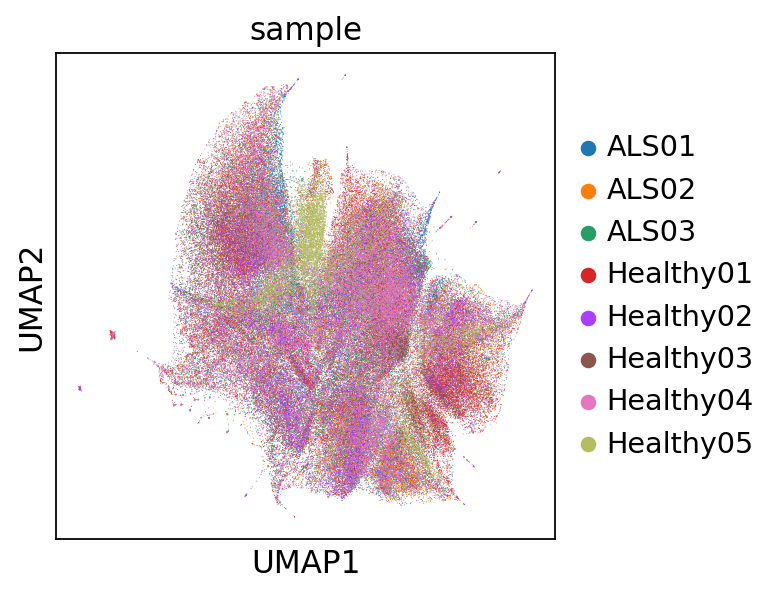

In [11]:
sc.pl.umap(adata, color='sample')

/data/je30bery/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


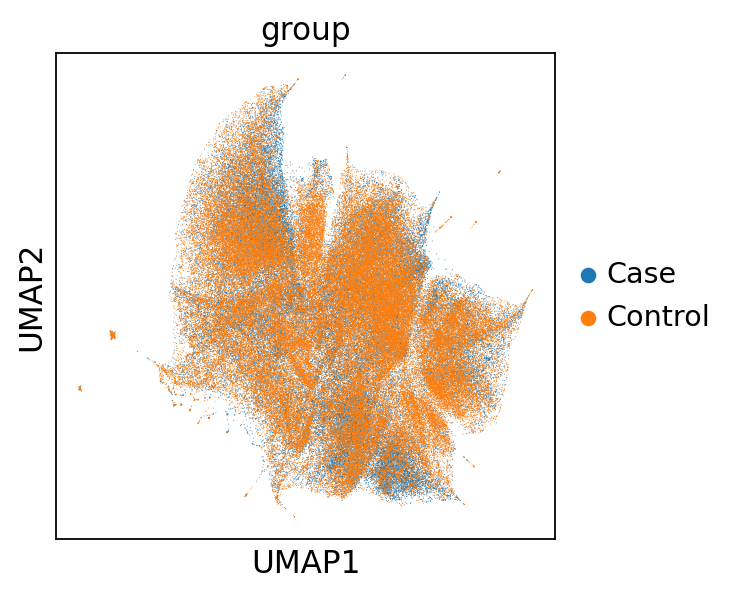

In [15]:
sc.pl.umap(adata, color='group')

/data/je30bery/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


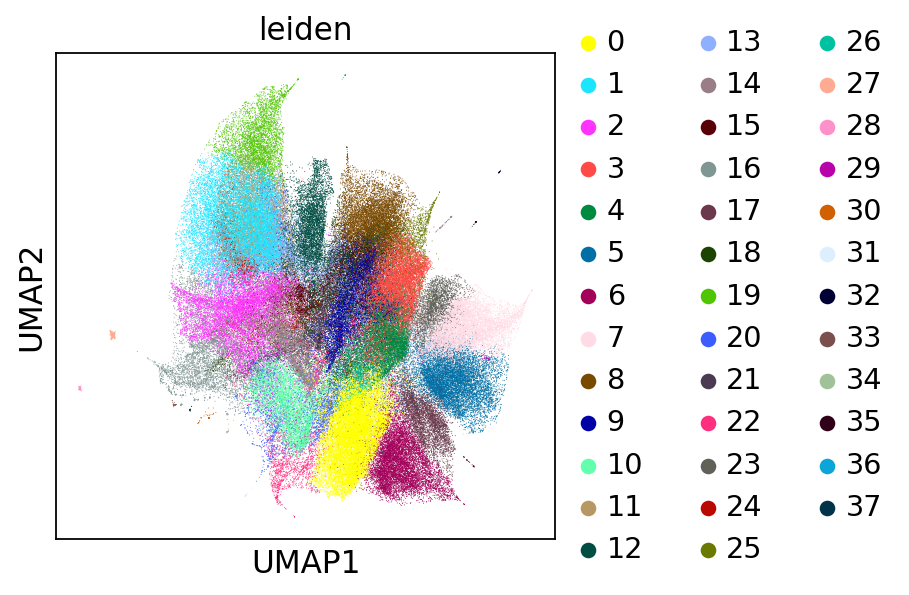

In [12]:
sc.pl.umap(adata, color='leiden')

In [ ]:
leiden = adata.obs["leiden"].values.to_numpy().astype(int)
sample = adata.obs["sample"].values.to_numpy().astype(str)
df = pd.DataFrame({"leiden": leiden, "sample": sample})

leiden_labels = np.unique(leiden)
samples = np.unique(sample)

conf = np.zeros((len(leiden_labels), len(samples)))
for i, l in enumerate(leiden_labels):
    for j, s in enumerate(samples):             
        conf[i,j] = len(np.where(sample[np.where(leiden == l)] == s)[0])

In [ ]:
conf_df = pd.DataFrame(conf, index=leiden_labels, columns=samples).T
conf_df["sum"] = conf_df.sum(axis=1)

In [ ]:
rel_conf = conf_df.iloc[:,:-1].div(conf_df["sum"], axis=0)

In [ ]:
sns.set(rc={'figure.figsize':(15, 5)})
sns.heatmap(rel_conf,square=True)

In [ ]:
expression_data["leiden"] = leiden

In [ ]:
binary_cluster_centers = np.zeros((len(leiden_labels), 19))
for i in range(len(leiden_labels)):
    (expression_data[expression_data["leiden"] == i].drop(["Sample", "Group"], axis=1).mean(axis=0) > 0).astype(int)
    binary_cluster_centers[i] = (expression_data[expression_data["leiden"] == i].drop(["Sample", "Group"], axis=1).mean(axis=0) > 0).astype(int)[:-1]

In [ ]:
binary_cluster_center_df = pd.DataFrame(binary_cluster_centers.T, index = expression_data.columns[:-3])

In [ ]:
binary_cluster_center_df["Patent profile"] = [0, 1] + [np.nan] * 13 + [0] + [np.nan] * 3
binary_cluster_center_df["Publication profile"] = [0, 1] + [np.nan] * 8 + [1] + [np.nan] * 8

In [ ]:
sns.set_theme()
sns.heatmap(binary_cluster_center_df)

In [ ]:
binary_cluster_center[1]

In [ ]:
cluster_center_1 = (expression_data[expression_data["leiden"] == 1].drop(["Sample", "Group"], axis=1).mean(axis=0) > 0).astype(int) 
cluster_center_1

In [ ]:
cluster_center_12 = (expression_data[expression_data["leiden"] == 12].drop(["Sample", "Group"], axis=1).mean(axis=0) > 0).astype(int)

In [ ]:
cluster_center_11 = (expression_data[expression_data["leiden"] == 11].drop(["Sample", "Group"], axis=1).mean(axis=0) > 0).astype(int)

In [ ]:
sns.histplot(data=df, x="leiden", y="sample", kde=True, bins=(30, 30))
plt.show()

In [ ]:
sample

In [ ]:
adata["leiden"]

In [ ]:
df = pd.DataFrame({'Sample': expression_data["Sample"].values, 'Leiden Cluster': cluster_labels.values})
cluster_counts = df.groupby(['Sample', 'Leiden Cluster']).size().unstack(fill_value=0)

# Set up the figure and axes for the bar plot
fig, ax = plt.subplots(figsize=(8, 6))

# Use Seaborn's barplot function to create the stacked bar plot
sns.barplot(data=cluster_counts, ax=ax, hue="Sample")

# Customize the plot
ax.set_xlabel('Sample')
ax.set_ylabel('Number of Cells')
ax.set_title('Cell Clusters by Sample Name')

# Rotate the x-axis labels if needed
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [ ]:
df

In [ ]:
adata

In [ ]:
adata

In [ ]:
def conf_heatmap(res_df, props1, props2):
    hm = np.zeros((len(np.unique(res_df[props1])), len(np.unique(res_df[props2]))))

    for i, p1 in enumerate(np.unique(res_df[props1])):
        for j, p2 in enumerate(np.unique(res_df[props2])):
            sub_df = res_df[res_df[props1]==p1]
            sub_df = sub_df[sub_df[props2]==p2]
            hm[i,j] = len(sub_df)

    sns.heatmap(hm, annot=True, xticklabels=np.unique(res_df[props2]), yticklabels=np.unique(res_df[props1]), vmin=0, vmax=len(res_df))
    plt.tight_layout()
    plt.show()

In [ ]:
conf_heatmap(res_df, props1="2-Means Label", props2="Group")

In [ ]:
conf_heatmap(res_df, props1="8-Means Label", props2="Group")

In [ ]:
conf_heatmap(res_df, props1="2-Means Label", props2="Sample")

In [ ]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(Xs_normalized)
res_df = ys.copy()
res_df["UMAP Dim1"] = embedding[:,0]
res_df["UMAP Dim2"] = embedding[:,1]

In [ ]:
plt.figure(figsize=(8,5))
sns.set_theme(style="white", palette=None)
sns.scatterplot(res_df, x="UMAP Dim1", y="UMAP Dim2", hue="Sample", s=2)
plt.title("UMAP on Expression Data (Cell-based), colored by Sample")
#plt.legend(loc="upper left")

plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig("umap_samples.png")
#plt.show()

In [ ]:
#reducer = umap.UMAP()
#embedding = reducer.fit_transform(Xs_normalized)
#res_df = ys.copy()
#res_df["UMAP Dim1"] = embedding[:,0]
#res_df["UMAP Dim2"] = embedding[:,1]
plt.clf()
plt.figure(figsize=(8,5))
sns.set_theme(style="white", palette=None)
sns.scatterplot(res_df, x="UMAP Dim1", y="UMAP Dim2", hue="Group", s=1)
plt.title("UMAP on Expression Data (Cell-based), colored by Case/Control")
#plt.legend(loc="upper left")

plt.legend(bbox_to_anchor=(1.155, 1))
plt.tight_layout()
plt.savefig("umap_condition.png")
#plt.show()

In [ ]:
pca = PCA(2)
res = pca.fit_transform(Xs_normalized)
res_df = ys.copy()
res_df["PCA Dim1"] = res[:,0]
res_df["PCA Dim2"] = res[:,1]

In [ ]:
plt.figure(figsize=(8,5))
sns.set_theme(style="white", palette=None)
sns.scatterplot(res_df, x="PCA Dim1", y="PCA Dim2", hue="Sample", alpha=0.5, s=1)
plt.title("PCA on Expression Data (Cell-based), colored by Sample")
#plt.legend(loc="upper left")

plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig("pca_samples.png")
#plt.show()

In [ ]:
plt.figure(figsize=(8,5))
sns.set_theme(style="white", palette=None)
sns.scatterplot(res_df, x="PCA Dim1", y="PCA Dim2", hue="Group", alpha=0.5, s=1)
plt.title("UMAP on Expression Data (Cell-based), colored by Case/Control")
#plt.legend(loc="upper left")

plt.legend(bbox_to_anchor=(1.155, 1))

plt.tight_layout()
plt.savefig("pca_condition.png")
#plt.show()

In [ ]:
conf_heatmap(res_df, props1="8-Means Label", props2="Sample")